The goal here is to evaluate the errors introduced adversarial training by a bit-wise comparison of the original weight values with the modified values.

In [86]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [87]:
origWeights = np.load('origWeights.npy')
modifiedWeights = np.load('modifiedWeights.npy')
origBiases = np.load('origBiases.npy')
modifiedBiases = np.load('modifiedBiases.npy')

In [88]:
def compute_minAndMax(listArrays):
    '''
    Function to find the smallest and largest elements 
    in a list of numpy arrays
    '''
    minVal = np.inf
    maxVal = -np.inf
    for arr in listArrays:
        if arr.min() < minVal:
            minVal = arr.min()
        if arr.max() > maxVal:
            maxVal = arr.max()
    return minVal, maxVal

In [89]:
def scale_weights(listArrays, scaleFunc):
    '''
    scale the values in a list of arrays based on scaleFunc
    '''
    scaledListArrays = []
    for arr in listArrays:
        scaledArray = scaleFunc(arr)
        scaledListArrays.append(scaledArray)
    return scaledListArrays

In [90]:
def convert_toBinary(decFrac, res):
    '''
    Implements the standard algorithm used to convert a decimal 
    fraction into binary.
    Accepts a decimal value between 0 and 1 and returns a list of 
    0s and 1s corresponding to its binary representation. res 
    represents the bit resolution and determines the length of
    the list.
    '''
    binRep = []
    for i in range(res):
        decFrac = decFrac * 2
        binRep.append(int(decFrac))
        if int(decFrac) == 1:
            decFrac -= 1
    return binRep

In [91]:
convert_toBinary(0.499999999, 16)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [92]:
def convert_seqToBinary(listArrays, res):
    '''
    Creates 1-D arrays of lists corresponding to the binary 
    representations of the elements in each of the arrays.
    The shape of the original array is not preserved.
    '''
    binListArrays = []
    for arr in listArrays:
        binArray = []
        for val in np.nditer(arr):
            binArray.append(convert_toBinary(val, res))
        binListArrays.append(binArray)
    return binListArrays

In [93]:
def convert_toFraction(origValues, modifiedValues):
    '''
    computes the min and max considering all input values, 
    and maps all the values into [0-1)
    '''
    # Both original as well as modified vlaues are considered while 
    # finding the minimum and maximum; this ensures that all values 
    # are between 0 and 1
    origMin, origMax = compute_minAndMax(origValues)
    modifiedMin, modifiedMax = compute_minAndMax(modifiedValues)
    minThres = min(origMin, modifiedMin)
    # Since we don't want to map any of the values to 1, maxThres 
    # is set to be slightly larger than the maximum.
    maxThres = max(origMax, modifiedMax) + 1e-5
    scaleFunc = lambda x : (x - minThres)/(maxThres - minThres)
    scaledOrigValues = scale_weights(origValues, scaleFunc)
    scaledModifiedValues = scale_weights(modifiedValues, scaleFunc)
    return scaledOrigValues, scaledModifiedValues

def compute_bitErrorRate(scaledOrigWeights, scaledModifiedWeights, res):
    '''
    Takes original and modified values in [0-1) as input, and 
    computes BER by comparing their binary representations
    '''
    binOrigWeights = convert_seqToBinary(scaledOrigWeights, res)
    binModifiedWeights = convert_seqToBinary(scaledModifiedWeights, res)
    # Once the values are converted into binary, we want to iterate 
    # through the lists to compare the bit values in the original and 
    # modified arrays.
    numLayers = len(scaledOrigWeights)
    numBitErrors = np.zeros((numLayers, res), np.uint32)
    numBitVals = np.zeros((numLayers, res), np.uint32)
    for layerNo, (binOrigWeightsLayer, binModifiedWeightsLayer
                 ) in enumerate(zip(binOrigWeights, binModifiedWeights)):
        for binOrigWeight, binModifiedWeight in zip(
            binOrigWeightsLayer, binModifiedWeightsLayer):
            for bitPos, (origBit, modifiedBit
                        ) in enumerate(zip(binOrigWeight, binModifiedWeight)):
                numBitVals[layerNo][bitPos] += 1
                if origBit != modifiedBit:
                    numBitErrors[layerNo][bitPos] += 1
    bitErrorRates = numBitErrors/numBitVals
    return bitErrorRates

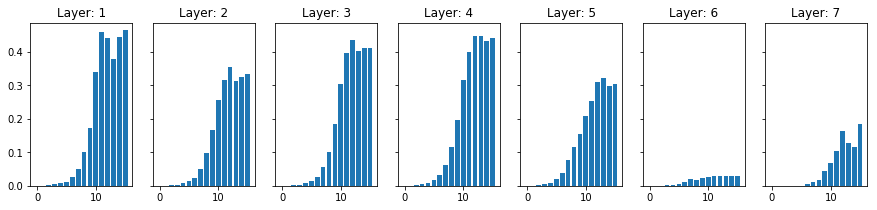

In [94]:
BIT_RESOLUTION = 16
# First, scale the weights into [0,1)
scaledOrigWeights, scaledModifiedWeights = convert_toFraction(
    origWeights, modifiedWeights)
# scaled_origWeights and scaled_modifiedWeights are in [0-1), and we want
# to convert them into binary.
ber = compute_bitErrorRate(
    scaledOrigWeights, scaledModifiedWeights, BIT_RESOLUTION)
numLayers = len(origWeights)
f, axarr = plt.subplots(1,numLayers, sharey=True, figsize=(15,3))
for layerNo in range(numLayers):
    axarr[layerNo].bar(np.arange(BIT_RESOLUTION), ber[layerNo])
    axarr[layerNo].set_title('Layer: ' + str(layerNo+1))

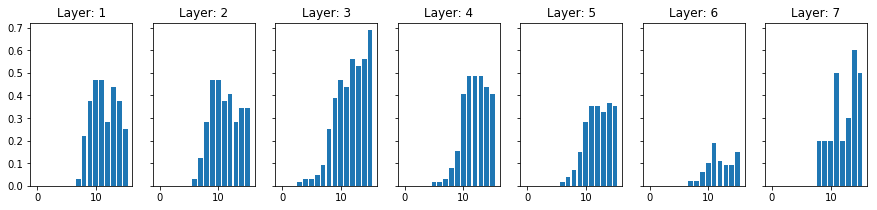

In [95]:
# First, scale the Biases into [0,1)
scaledOrigBiases, scaledModifiedBiases = convert_toFraction(
    origBiases, modifiedBiases)
# scaled_origBiases and scaled_modifiedBiases are in [0-1), and we want
# to convert them into binary.
ber = compute_bitErrorRate(
    scaledOrigBiases, scaledModifiedBiases, BIT_RESOLUTION)
f, axarr = plt.subplots(1,numLayers, sharey=True, figsize=(15,3))
for layerNo in range(numLayers):
    axarr[layerNo].bar(np.arange(BIT_RESOLUTION), ber[layerNo])
    axarr[layerNo].set_title('Layer: ' + str(layerNo+1))

In [96]:
def measure_noise(origValues, modifiedValues):
    noiseValues = []
    for origArr, modifiedArr in zip(origValues, modifiedValues):
        # error_arr is the element-wise difference of all values in the array
        errorArr = origArr - modifiedArr
        noiseValues.append(errorArr)
    return noiseValues

In [97]:
origWeights[0].shape

(3, 3, 3, 32)

In [98]:
# The first 3 layers are convolutional layers
r = measure_noise(origWeights[:5], modifiedWeights[:5])
min_noise, max_noise = compute_minAndMax(r)
print(min_noise, max_noise)

-0.006666747 0.0061040074


(-0.5, 3.5, 3.5, -0.5)

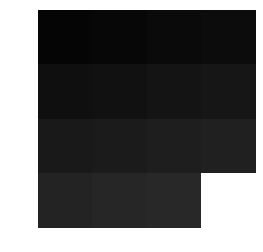

In [99]:
H = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 100]])  # added some commas and array creation code
plt.imshow(H, cmap='gray', vmin=-1, vmax=100)
plt.axis('off')

In [100]:
for layer in r:
    print(layer.T.shape)
allMatrices = []
colors = []
color = ['r', 'g', 'b', 'y', 'c']
#color = ['r', 'g', 'b']
for layer,c in zip(r,color):
    for filter in layer.T:
        for matrix in filter:
            allMatrices.append(matrix.flatten())
            colors.append(c)
allMatrices_tsne = TSNE(n_components=2, perplexity=100, n_iter=1200).fit_transform(allMatrices)
print(allMatrices_tsne.shape)

(32, 3, 3, 3)
(32, 32, 3, 3)
(64, 32, 3, 3)
(64, 64, 3, 3)
(128, 64, 3, 3)
(15456, 2)


Text(0.5, 1.0, 'Model Noise')

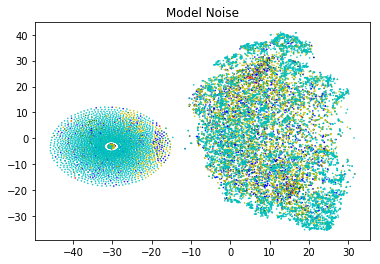

In [101]:
allMatrices_x, allMatrices_y = allMatrices_tsne.T
# plt.figure(figsize=(10,10))
plt.scatter(allMatrices_x, allMatrices_y, s=0.3, c=colors)
plt.title('Model Noise')

Text(0.5, 1.0, 'Model Noise')

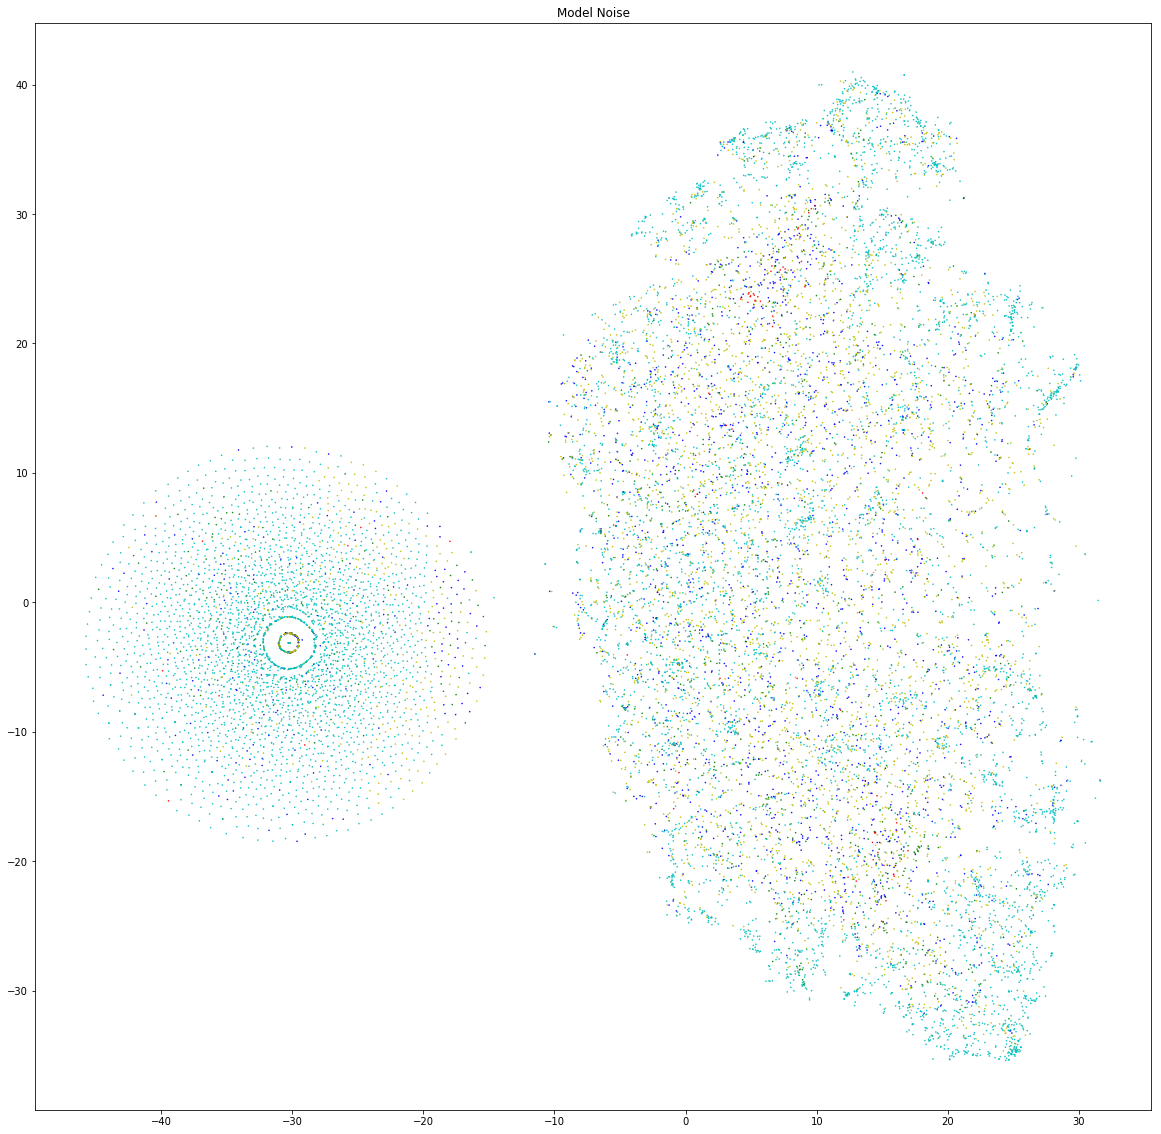

In [102]:
allMatrices_x, allMatrices_y = allMatrices_tsne.T
plt.figure(figsize=(20,20))
plt.scatter(allMatrices_x, allMatrices_y, s=0.3, c=colors)
plt.title('Model Noise')

In [129]:
indices = (allMatrices_x < -29) * (allMatrices_y < -2) * (allMatrices_x > -31.5) * (allMatrices_y > -4)

In [130]:
len(np.nonzero(indices)[0])

302

Text(0.5, 1.0, 'Model Noise')

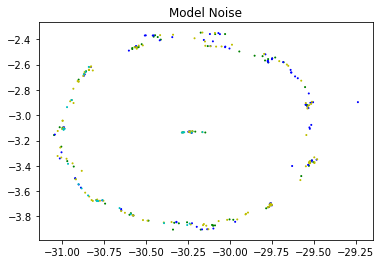

In [131]:
colors = np.array(colors)
plt.scatter(allMatrices_x[indices], allMatrices_y[indices], c = colors[indices], s=1)
plt.title('Model Noise')

In [132]:
np.nonzero(indices)[0][:80]

array([ 120,  123,  129,  131,  151,  152,  155,  301,  312,  315,  321,
        323,  333,  344,  355,  365,  856,  859,  865,  867,  877,  888,
        891,  899,  909,  920,  923,  931,  941,  951,  952,  955,  963,
       1005, 1008, 1015, 1016, 1019, 1059, 1069, 1079, 1080, 1083, 1088,
       1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099,
       1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110,
       1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1131, 1135,
       2335, 2347, 2351])

In [ ]:
allRandom = []
for i in range(6176):
    randomFilter = (max_noise - min_noise) * np.random.random((3,3)) + min_noise
    allRandom.append(randomFilter.flatten())
allRandom_tsne = TSNE(n_components=2, perplexity=40, n_iter=1200).fit_transform(allRandom)

In [ ]:
allRandom_x, allRandom_y = allRandom_tsne.T
plt.scatter(allRandom_x, allRandom_y, s=0.3)
plt.title('Random Noise')

In [ ]:
allMatrices.append(allRandom)
print(len(allMatrices))

In [ ]:
H = np.transpose(r[2])
f, axarr = plt.subplots(2,5, figsize=(15,7))
for num in range(10):
    axarr[num//5][num%5].imshow(H[num][0], cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()

In [ ]:
f, axarr = plt.subplots(2,5, figsize=(15,7))
for num in range(10):
    H = (max_noise - min_noise) * np.random.random((3,3)) + min_noise
    axarr.ravel()[num].imshow(H, cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()